In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


## data loading

In [2]:
path = os.path.join("data_set","train.csv")
df = pd.read_csv(path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data visualization

<Axes: xlabel='SalePrice', ylabel='Count'>

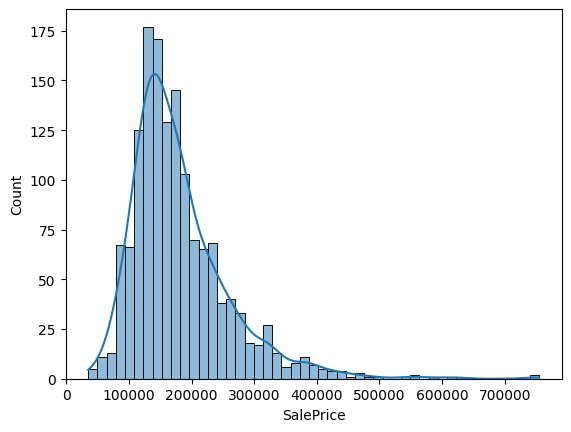

In [4]:
sns.histplot(data = df['SalePrice'],kde = True)

Respone data is skewed to the right. Log transformation is used to address skweness.

<Axes: xlabel='LogSalePrice', ylabel='Count'>

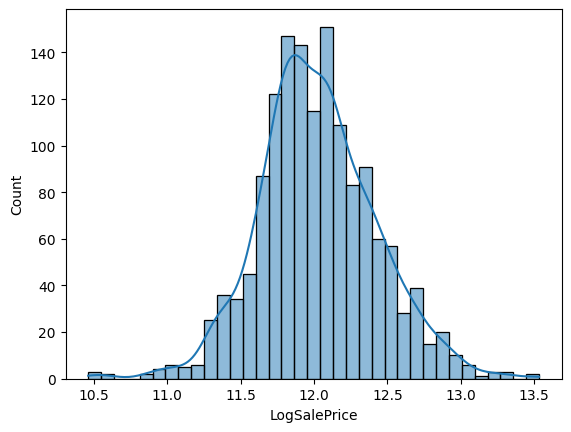

In [5]:
df['LogSalePrice'] = np.log(df['SalePrice'])
sns.histplot(data = df['LogSalePrice'],kde = True)

## Imputation

In [6]:
# how may missing data are here in train data
null_count = df.isnull().sum().sort_values(ascending=False)
(null_count[null_count>0] / 1460) *100 # percentage of null for a feature

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

In [7]:
# how may missing data are here in test data
null_count = df.isnull().sum().sort_values(ascending=False)
(null_count[null_count>0] / 1460) *100 # percentage of null for a feature

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageCond       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

Features with > 60 % null values will be dropped as they are not informative. Features with <30 % null values will be imputed. For in between values, I will decide dropping according to feature importances.
'PoolQC,MiscFeature,Alley,Fence' are dropped.
I will check feature importances of 'MasVnrType,FireplaceQu'.
The rest are kept.
Dropping features are considered according to train data only.  

In [8]:
df.drop(columns = ['PoolQC','MiscFeature','Alley','Fence'],inplace = True) #drop columns with too many nulls

Should i drop 'MasVnrType,FireplaceQu'?

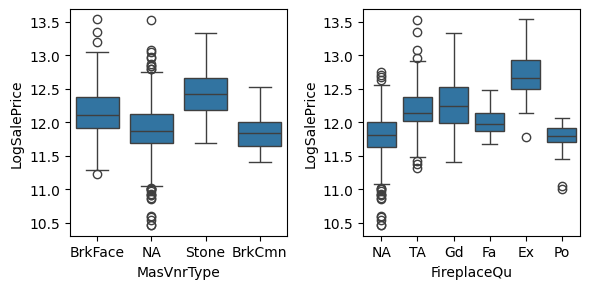

In [9]:
# should i drop 'MasVnrType,FireplaceQu'
fig, axes = plt.subplots(1, 2,figsize= (6,3))  # 1 row, 2 columns subplot
df['MasVnrType'] = df['MasVnrType'].fillna('NA') # null values mean there is no MasVnr
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA') #null values mean there is no Masonry veneer
sns.boxplot(x='MasVnrType', y='LogSalePrice', data=df, ax=axes[0])  # First subplot
sns.boxplot(x='FireplaceQu', y='LogSalePrice', data=df, ax=axes[1])  # Second subplot
plt.tight_layout()

Box plots show effects of these two features on LogSalePrice.I will keep this.

I will do imputation on other features.

In [10]:
df['MasVnrType'] = df['MasVnrType'].fillna('NA')
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')
df[['GarageQual','GarageFinish','GarageType','GarageCond']] = df[['GarageQual','GarageFinish','GarageType','GarageCond']].fillna('NA') #no garage
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(1890) # min year is 1900, since no garage should have lower house price, it is imputed with year 1890     
df[['BsmtExposure','BsmtFinType2','BsmtQual','BsmtFinType1','BsmtCond']] = df[['BsmtExposure','BsmtFinType2','BsmtQual','BsmtFinType1','BsmtCond']].fillna('NA') #no basement
df['LotFrontage'] = df['LotFrontage'].fillna(0)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0) 

For electrical system, every house should have one. I should impute with mode.

In [11]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

## Feature Engineering

In [12]:
def add_new_features(a):
    df = a
    df['BsmtFin'] = df['BsmtFinSF1']+ df['BsmtFinSF2']
    df['House_age'] = df['YrSold'] - df['YearBuilt']
    df['Remod_age'] = df['YrSold'] - df['YearRemodAdd']
    df['FlrSF'] = df['1stFlrSF'] +df['2ndFlrSF'] 
    df['Bath'] = df['HalfBath']+df['FullBath']
    df['AbvGrd'] = df['KitchenAbvGr']+df['BedroomAbvGr']
    df['OpenSF'] = df['WoodDeckSF'] + df['OpenPorchSF']+ df['EnclosedPorch']+ df['3SsnPorch']+df['ScreenPorch']
    df['bedroom/totalRoomAboveGrade'] = df['BedroomAbvGr'] / df['TotRmsAbvGrd']
    return df

In [13]:
#add new features
df = add_new_features(df)

## Remove Outliers

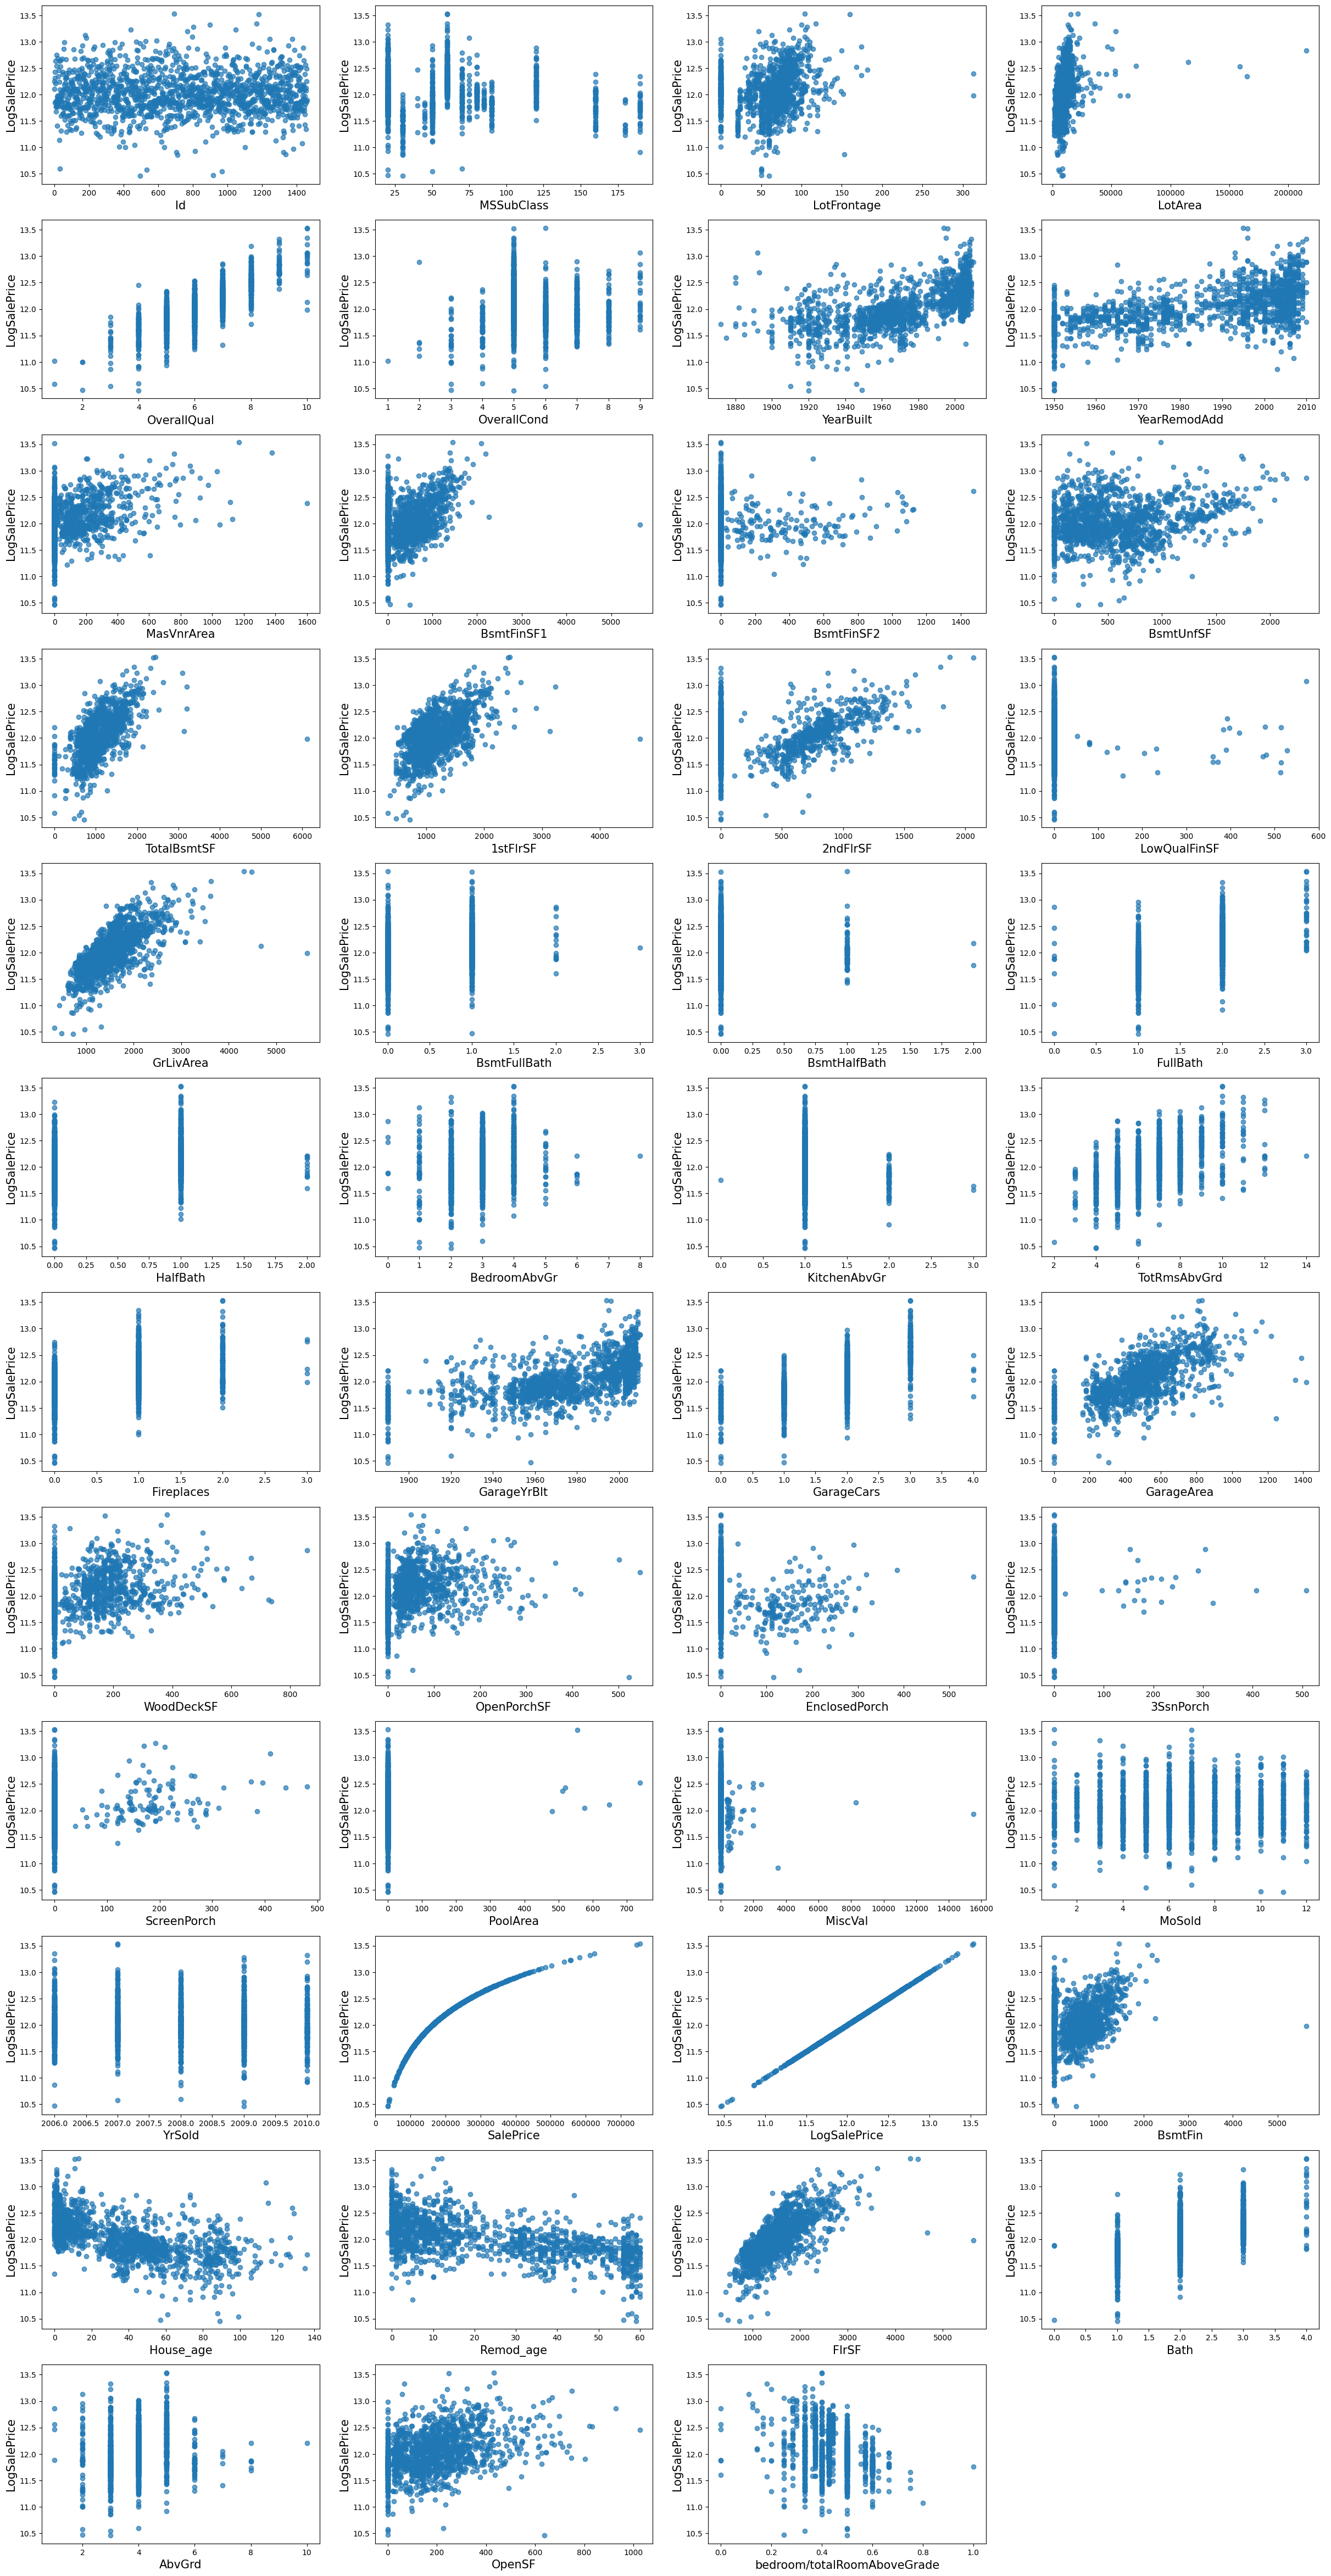

In [14]:
# Visualize relation of numerical features with response
numeric_column = df.select_dtypes(exclude='object').columns
fig,axes = plt.subplots(12,4,figsize= (30,60))
col = 0
for i in range(12):
    for j in range(4):
        if col < len(numeric_column):
            col_name = numeric_column[col]
            axes[i,j].scatter(df[col_name],df['LogSalePrice'],alpha = 0.7)
            axes[i,j].set_xlabel(col_name,fontsize = 15)
            axes[i,j].set_ylabel('LogSalePrice',fontsize = 15)
            col += 1
        else:
            axes[i, j].axis('off')   

In [15]:
#Manually remove datapoints that doesn't follow the trend 
df=df[~(df['LotFrontage']>300)]   
df=df[~(df['SalePrice']>700000)]
df=df[~(df['LotArea']>100000)]
df=df[~(df['MasVnrArea']>1250)]
df=df[~(df['BsmtFin']>4000)]
df=df[~(df['TotalBsmtSF']>3000)]
df=df[~(df['GarageArea']>1200)]

## Correlation 

C:\Users\Thurein Win Hein\AppData\Local\Temp\ipykernel_13604\2742621877.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].text(0.05, 0.95, f'Corr: {corr_Price[col]:.2f}',


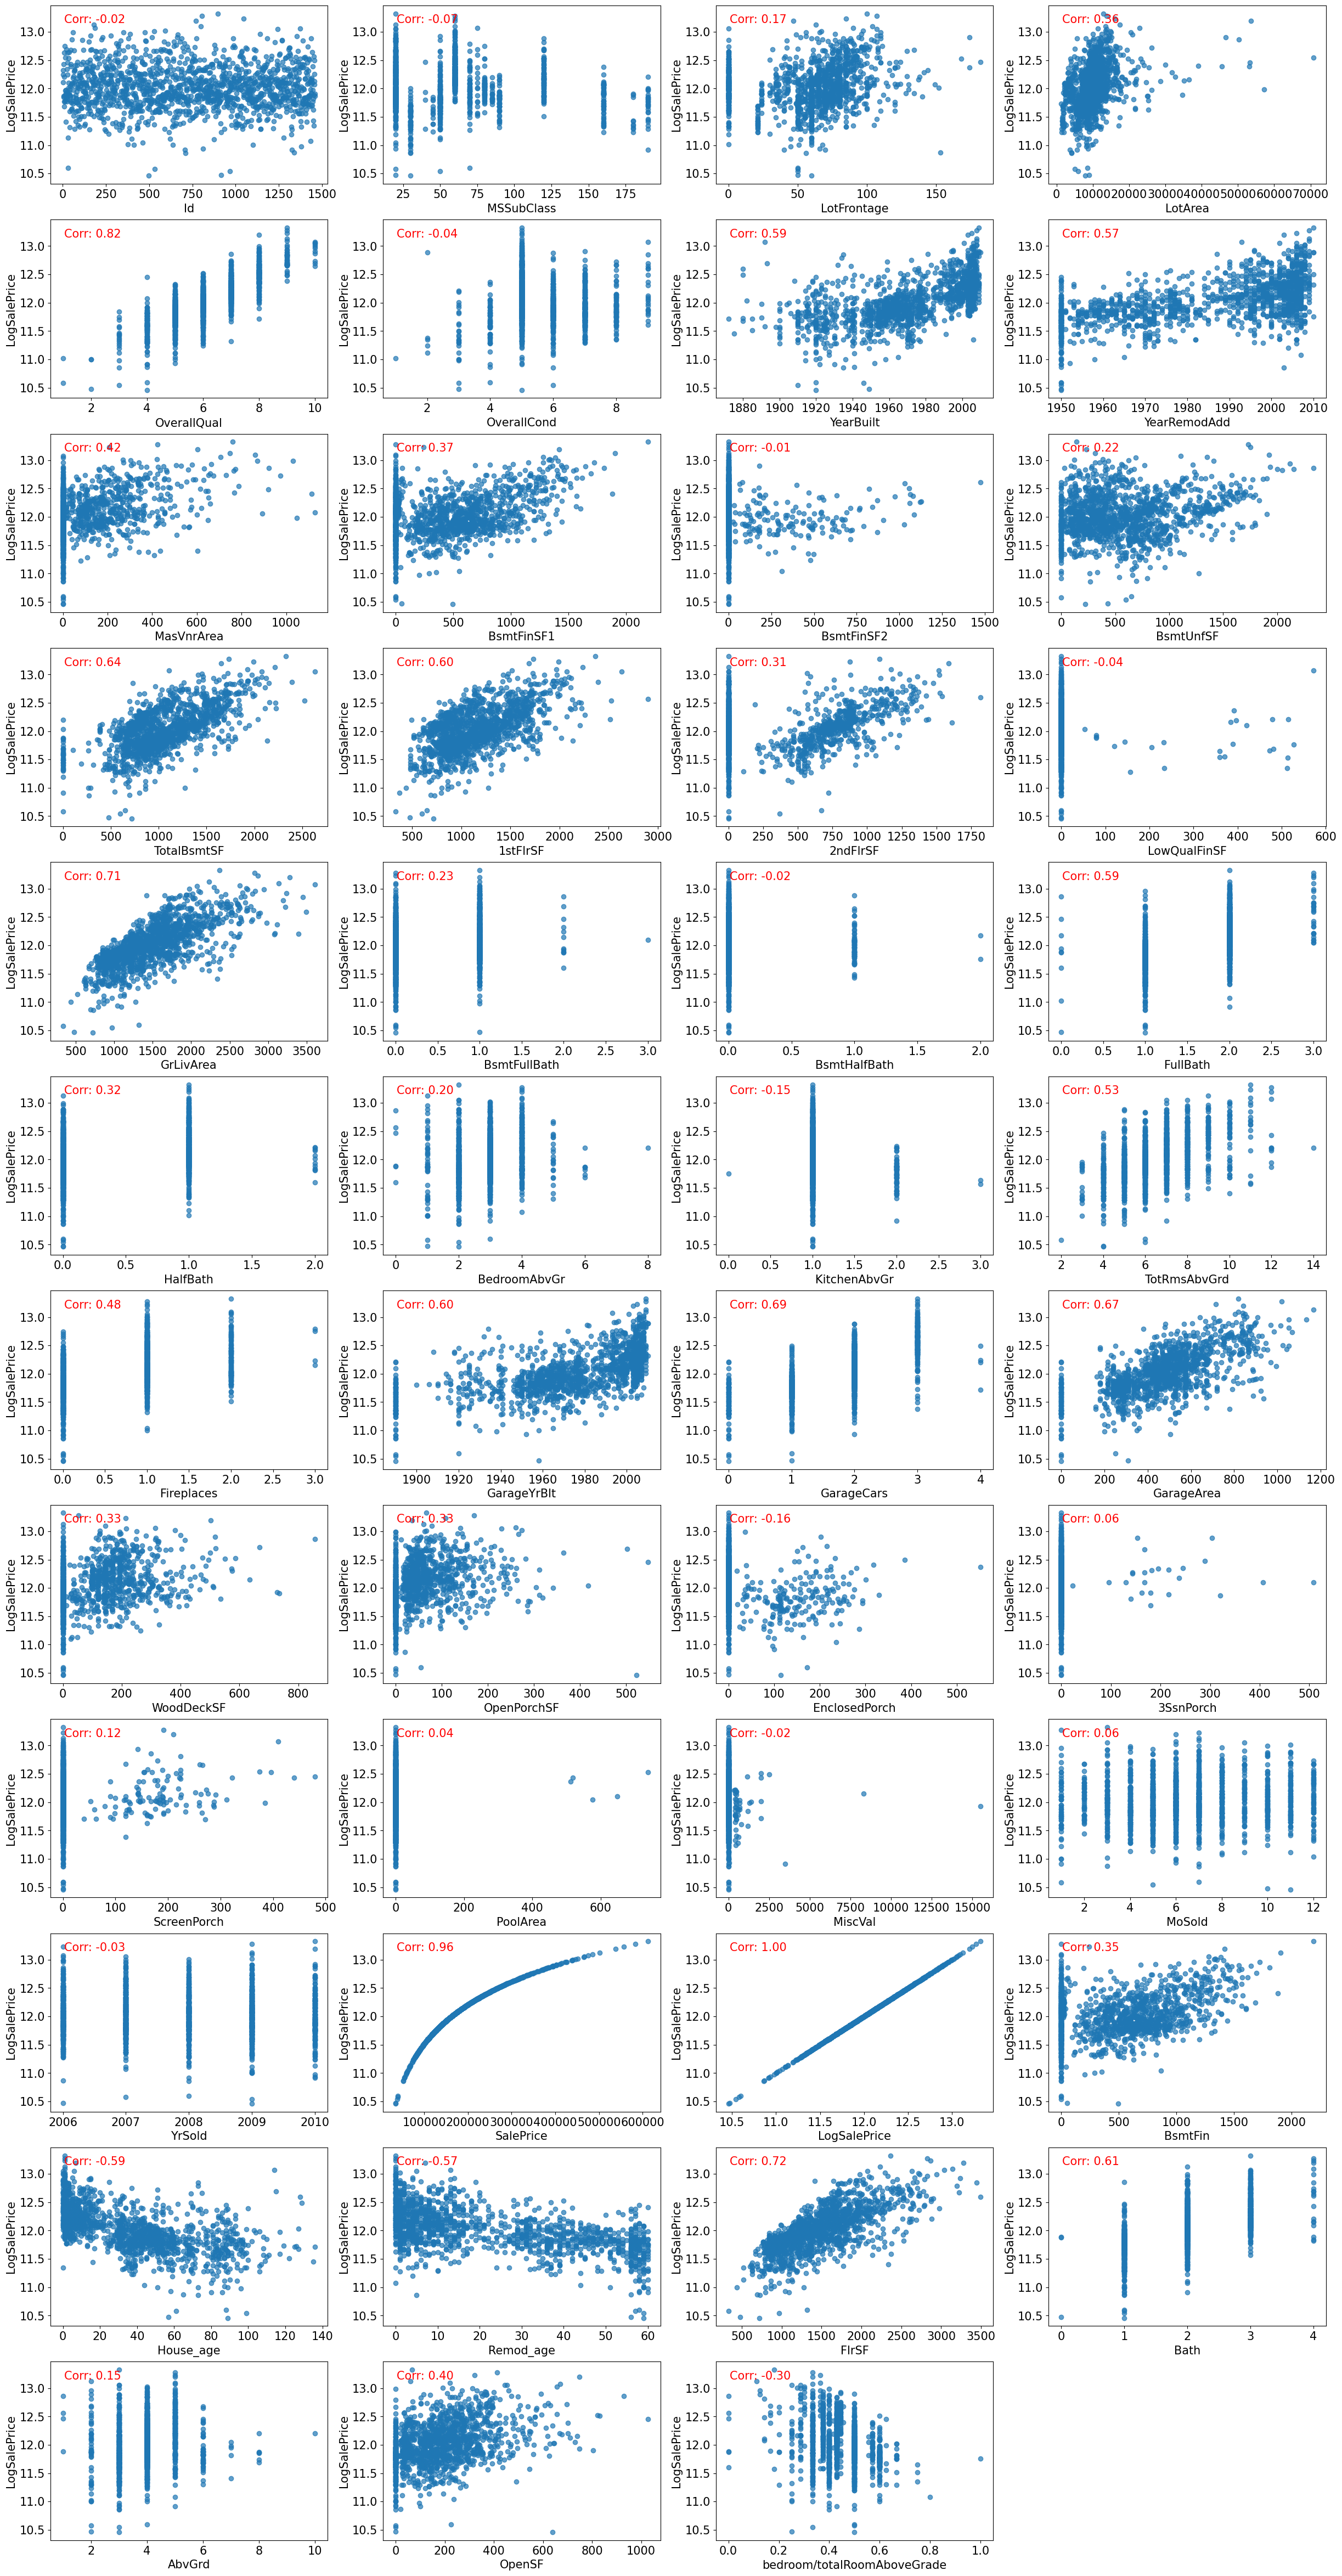

In [16]:
# checking correlation between numerical features and response
fig,axes = plt.subplots(12,4,figsize= (30,60))
corr = df[numeric_column].corr()
corr_Price = corr['LogSalePrice']
col = 0
for i in range(12):
    for j in range(4):
        if col < len(numeric_column):
            col_name = numeric_column[col]
            axes[i,j].scatter(df[col_name],df['LogSalePrice'],alpha = 0.7)
            axes[i,j].set_xlabel(col_name,fontsize = 15)
            axes[i,j].set_ylabel('LogSalePrice',fontsize = 15)
            axes[i,j].tick_params(axis='both', labelsize=15),
            axes[i,j].text(0.05, 0.95, f'Corr: {corr_Price[col]:.2f}', 
                            transform=axes[i, j].transAxes, fontsize=15,
                            verticalalignment='top', color='red')
            
            col += 1
        else:
            axes[i, j].axis('off')

There are two types of numerical features. Normal numerical features and interger numerical featres that acts like orinal data. The latter type cannot be determined by correlation score. 

In [17]:
numeric_ordinal = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath', 'BedroomAbvGr', 
                   'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces','GarageCars', 'Bath', 'AbvGrd']
numeric_normal = [i for i in numeric_column if i not in numeric_ordinal]

Drop numeric_normal features that have low correlation or low information.

In [18]:
df.drop(columns=['Id', 'YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'GarageYrBlt', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],inplace=True)

Check Correlation between each features

<Axes: >

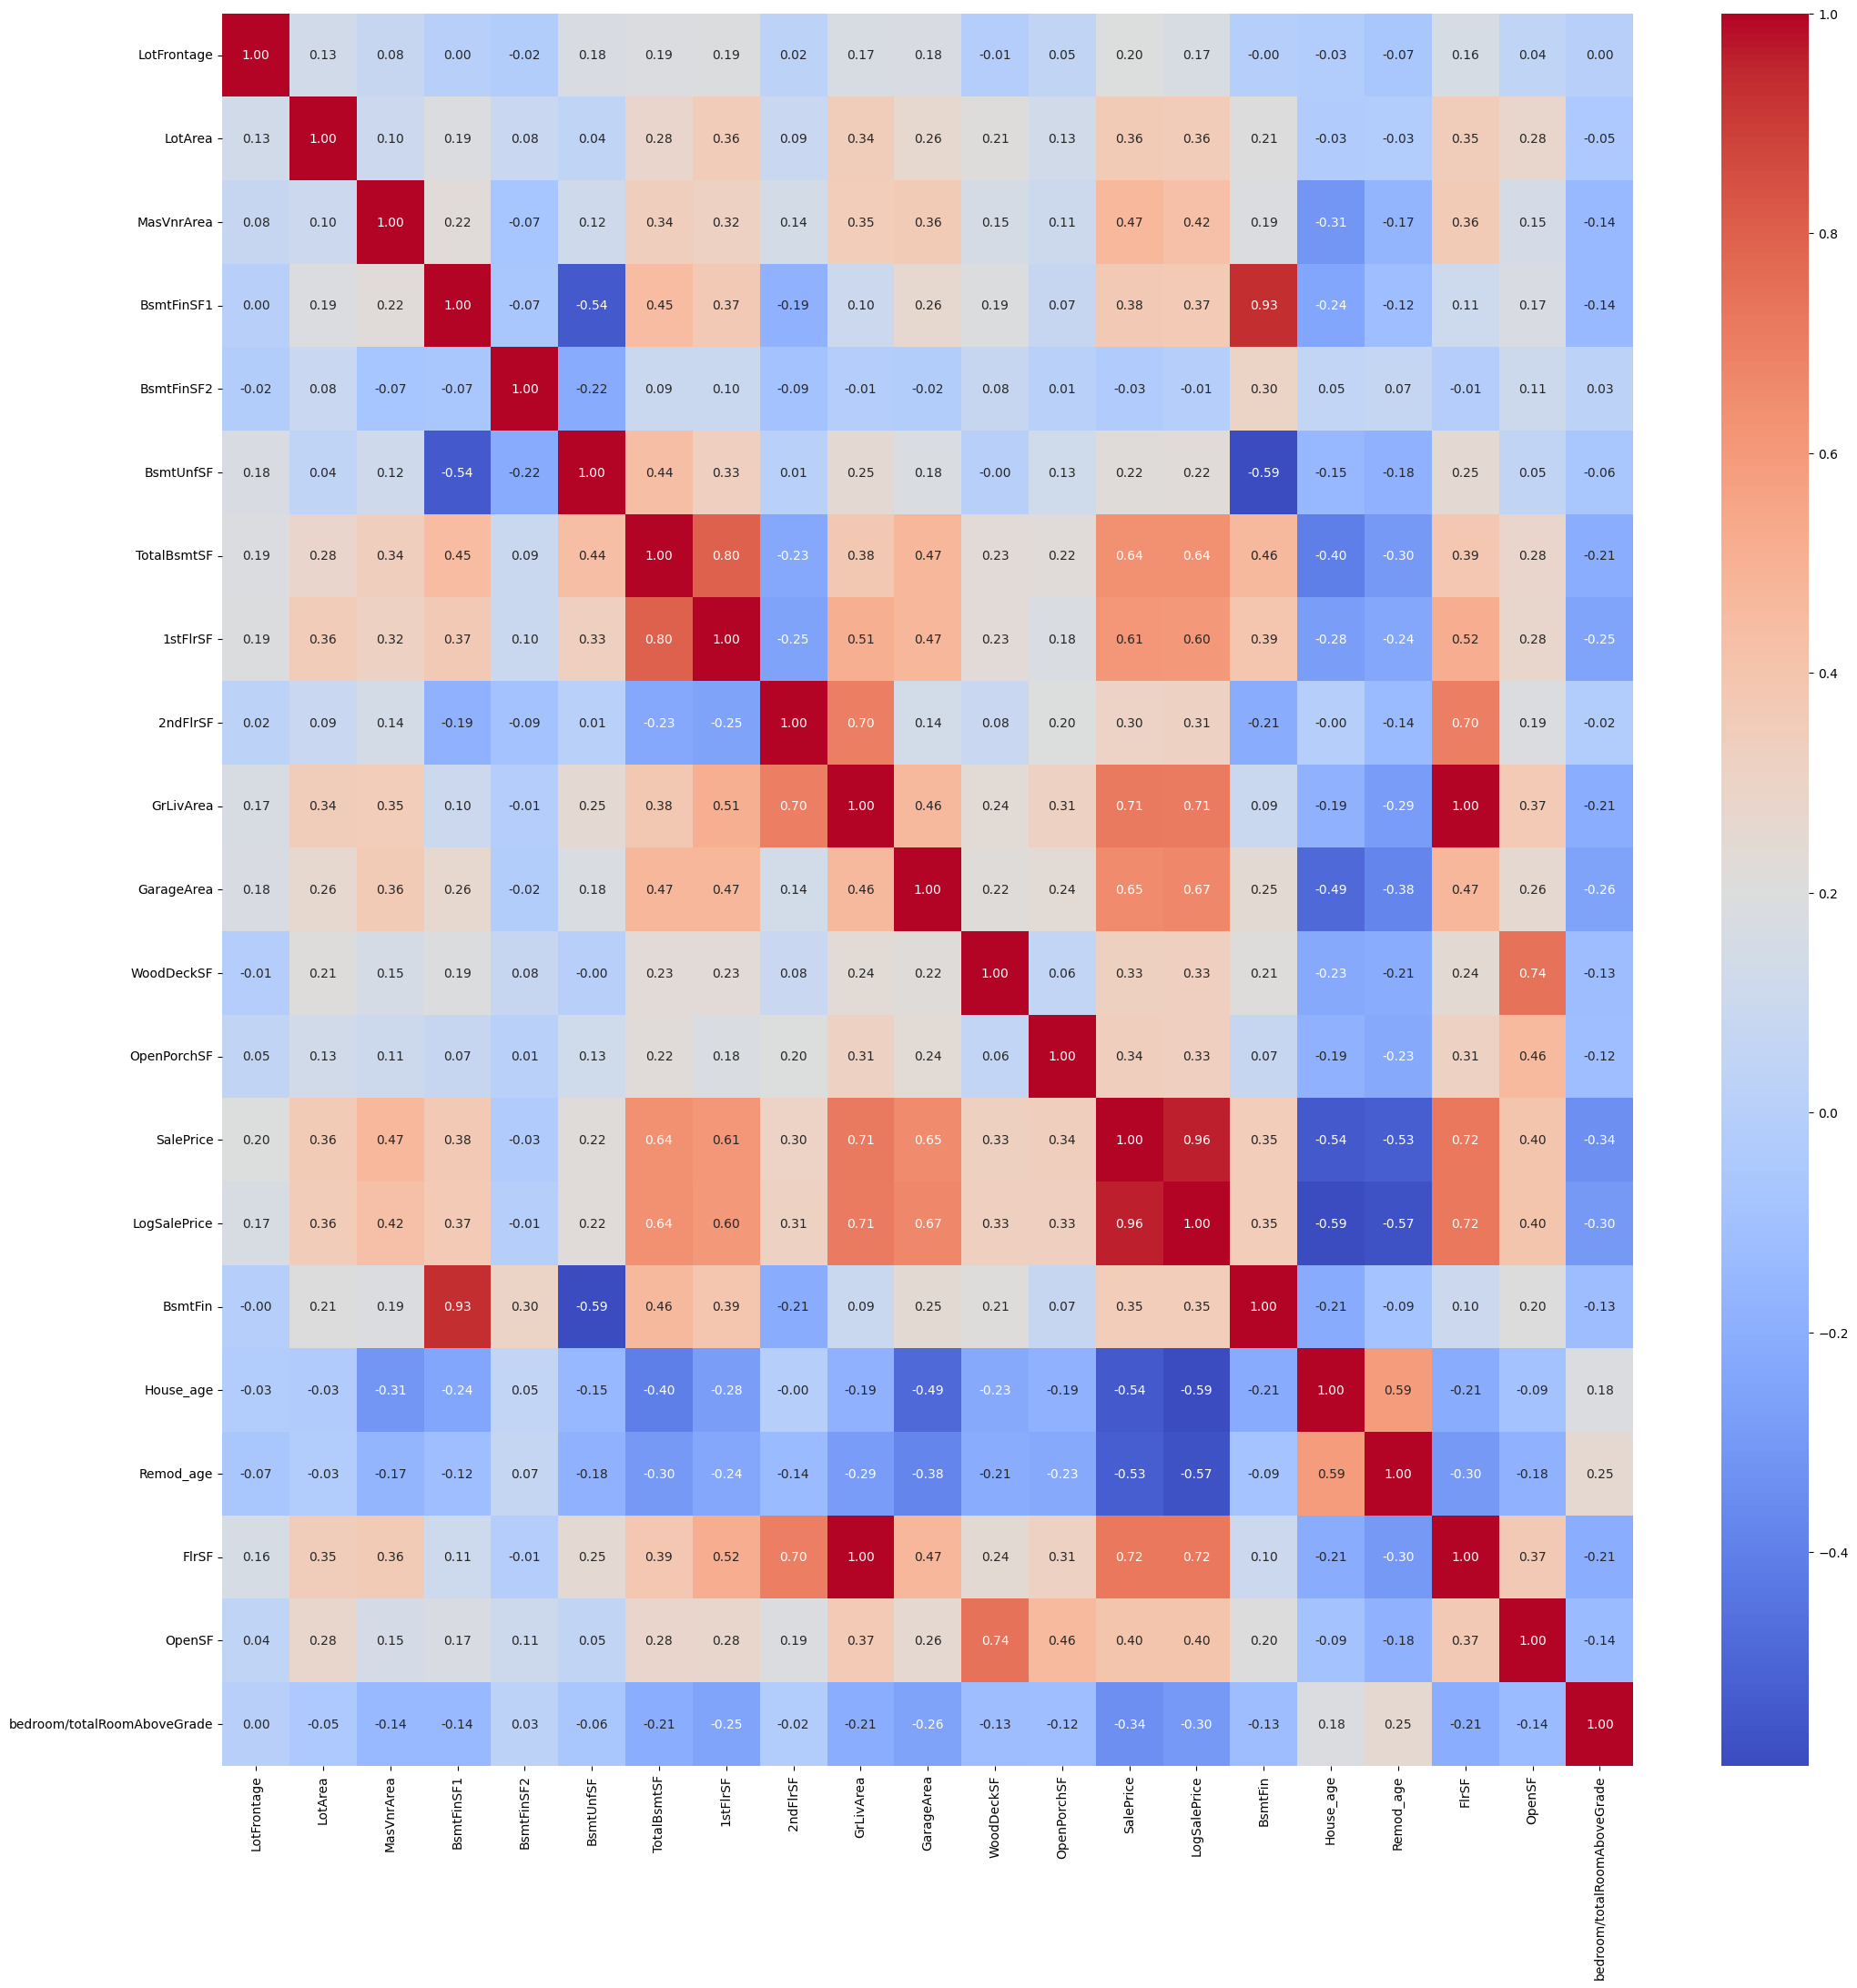

In [19]:
numeric_normal_new = [i for i in df.select_dtypes(exclude='object').columns if i not in numeric_ordinal] # new numerical normal features after dropping
corr = df[numeric_normal_new].corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr,cmap = 'coolwarm', annot = True, fmt='.2f')

In [20]:
#drop high correlation features
df.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF'],inplace = True)

In [21]:
numeric_normal_final = [i for i in df.select_dtypes(exclude='object') if i not in numeric_ordinal] #numeric features i will be using for machine learning
print(numeric_normal_final)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'LogSalePrice', 'BsmtFin', 'House_age', 'Remod_age', 'FlrSF', 'OpenSF', 'bedroom/totalRoomAboveGrade']


## numeric ordinal

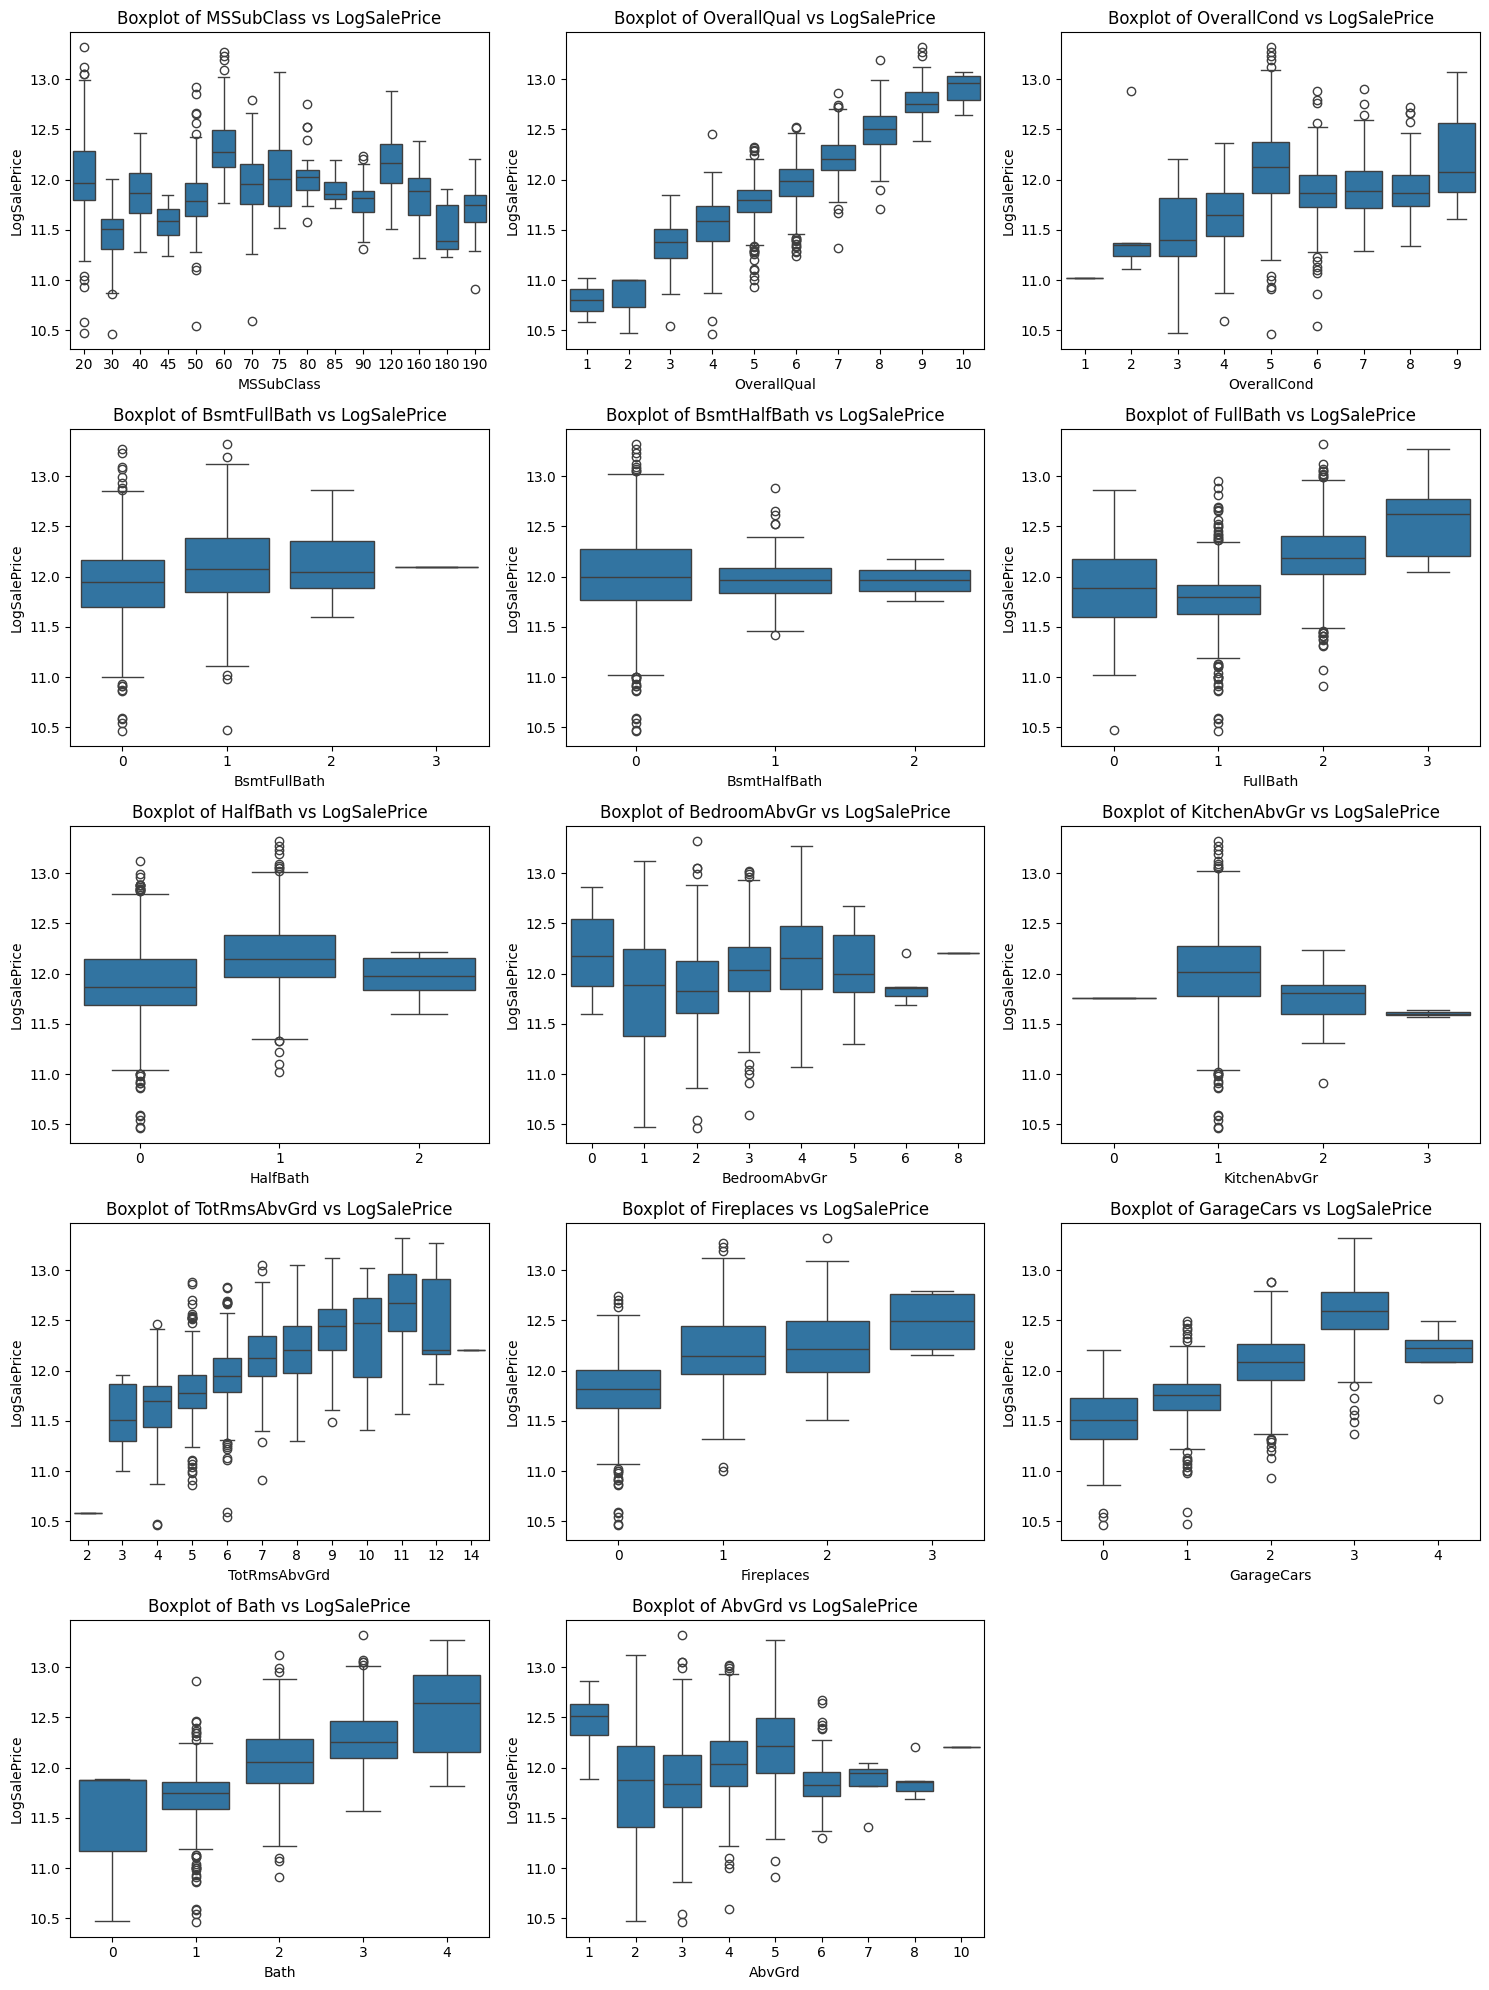

In [22]:
# Number of rows and columns for subplots
n_rows = 5
n_cols = 3


# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  

# Flatten the axes array for easy iteration
axes = axes.flatten()

for col, ax in enumerate(axes):
    if col < len(numeric_ordinal):
        col_name = numeric_ordinal[col]
        sns.boxplot(x=col_name, y='LogSalePrice', data=df, ax=ax)
        ax.set_title(f'Boxplot of {col_name} vs LogSalePrice')
    else:
        ax.axis('off')  # Hide unused subplots


plt.tight_layout()

In [23]:
#drop no effect features and already engineered fearures
df.drop(columns=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr'],inplace=True)


## Categoriacl Features

Threre are two types of categorical features. oridinal categories and normal categories.

In [24]:
cat_ordinal = ['LandSlope','ExterQual' , 'ExterCond' , 'BsmtQual' , 'BsmtExposure','BsmtFinType1',
               'BsmtFinType2','HeatingQC' ,'KitchenQual','FireplaceQu','GarageFinish','GarageQual' ,'GarageCond'] 

cat_normal = [i for i in df.select_dtypes(include= 'object').columns if i not in cat_ordinal]


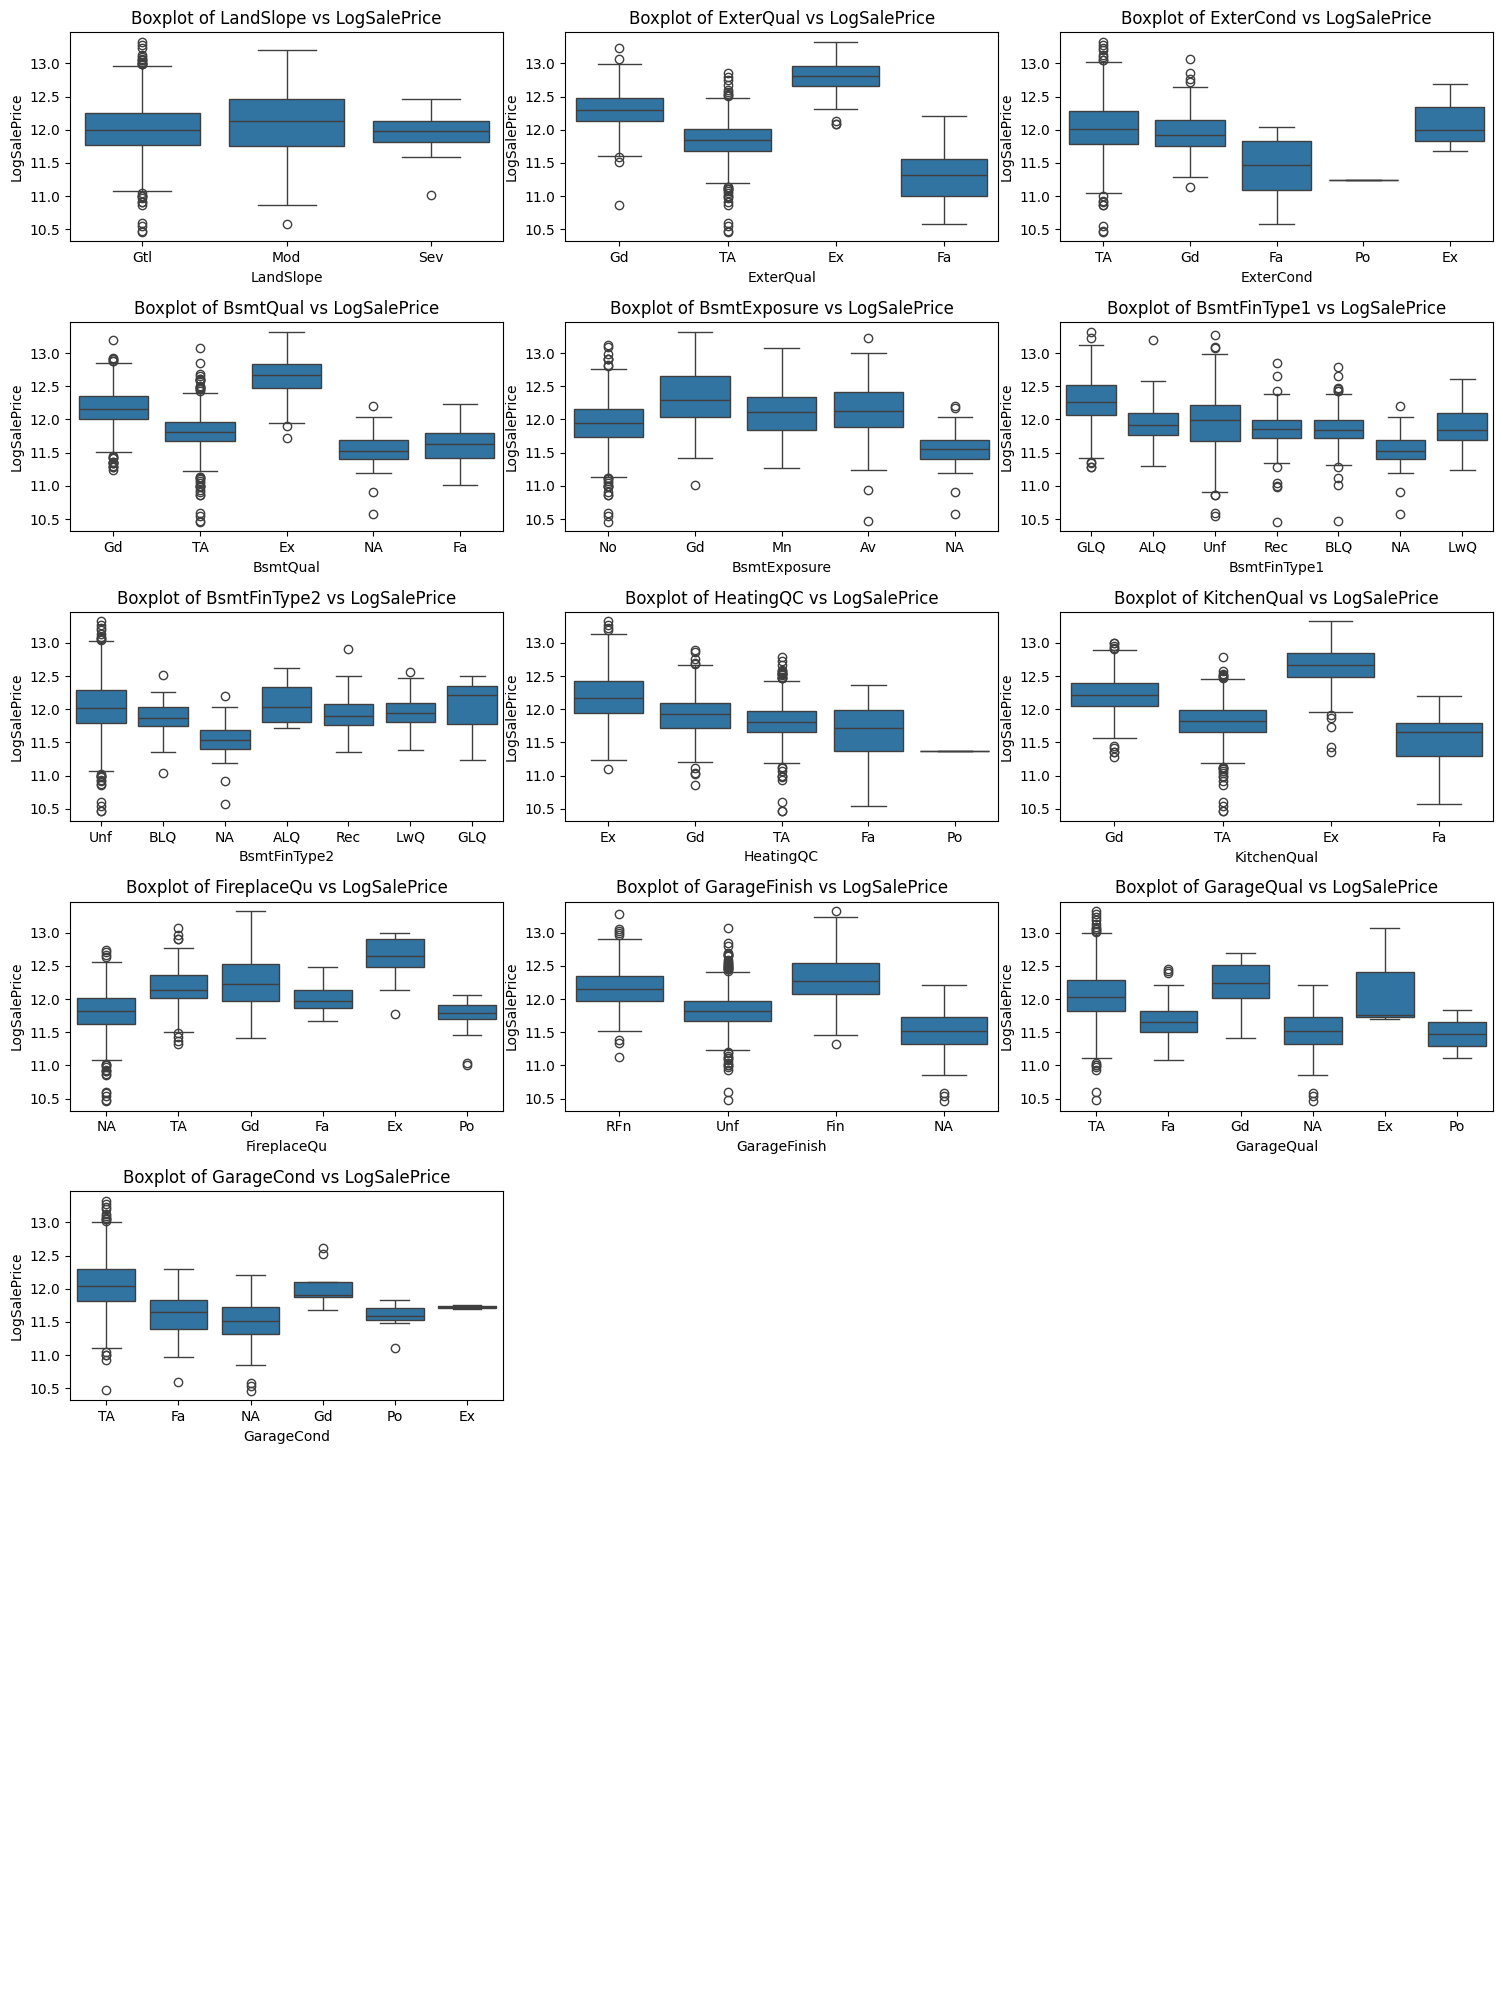

In [25]:
# box plots for ordinal categorical features
n_rows = 7
n_cols = 3


# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  

# Flatten the axes array for easy iteration
axes = axes.flatten()

for col, ax in enumerate(axes):
    if col < len(cat_ordinal):
        col_name = cat_ordinal[col]
        sns.boxplot(x=col_name, y='LogSalePrice', data=df, ax=ax)
        ax.set_title(f'Boxplot of {col_name} vs LogSalePrice')
    else:
        ax.axis('off')  # Hide unused subplots


plt.tight_layout()


In [26]:
# drop features with no effect
df.drop(columns = ['LandSlope'],inplace = True)

In [27]:
cat_ordinal = ['ExterQual' , 'ExterCond' , 'BsmtQual' , 'BsmtExposure','BsmtFinType1',
               'BsmtFinType2','HeatingQC' ,'KitchenQual','FireplaceQu','GarageFinish','GarageQual' ,'GarageCond'] 

cat_normal = [i for i in df.select_dtypes(include= 'object').columns if i not in cat_ordinal]

## Normal Category Features

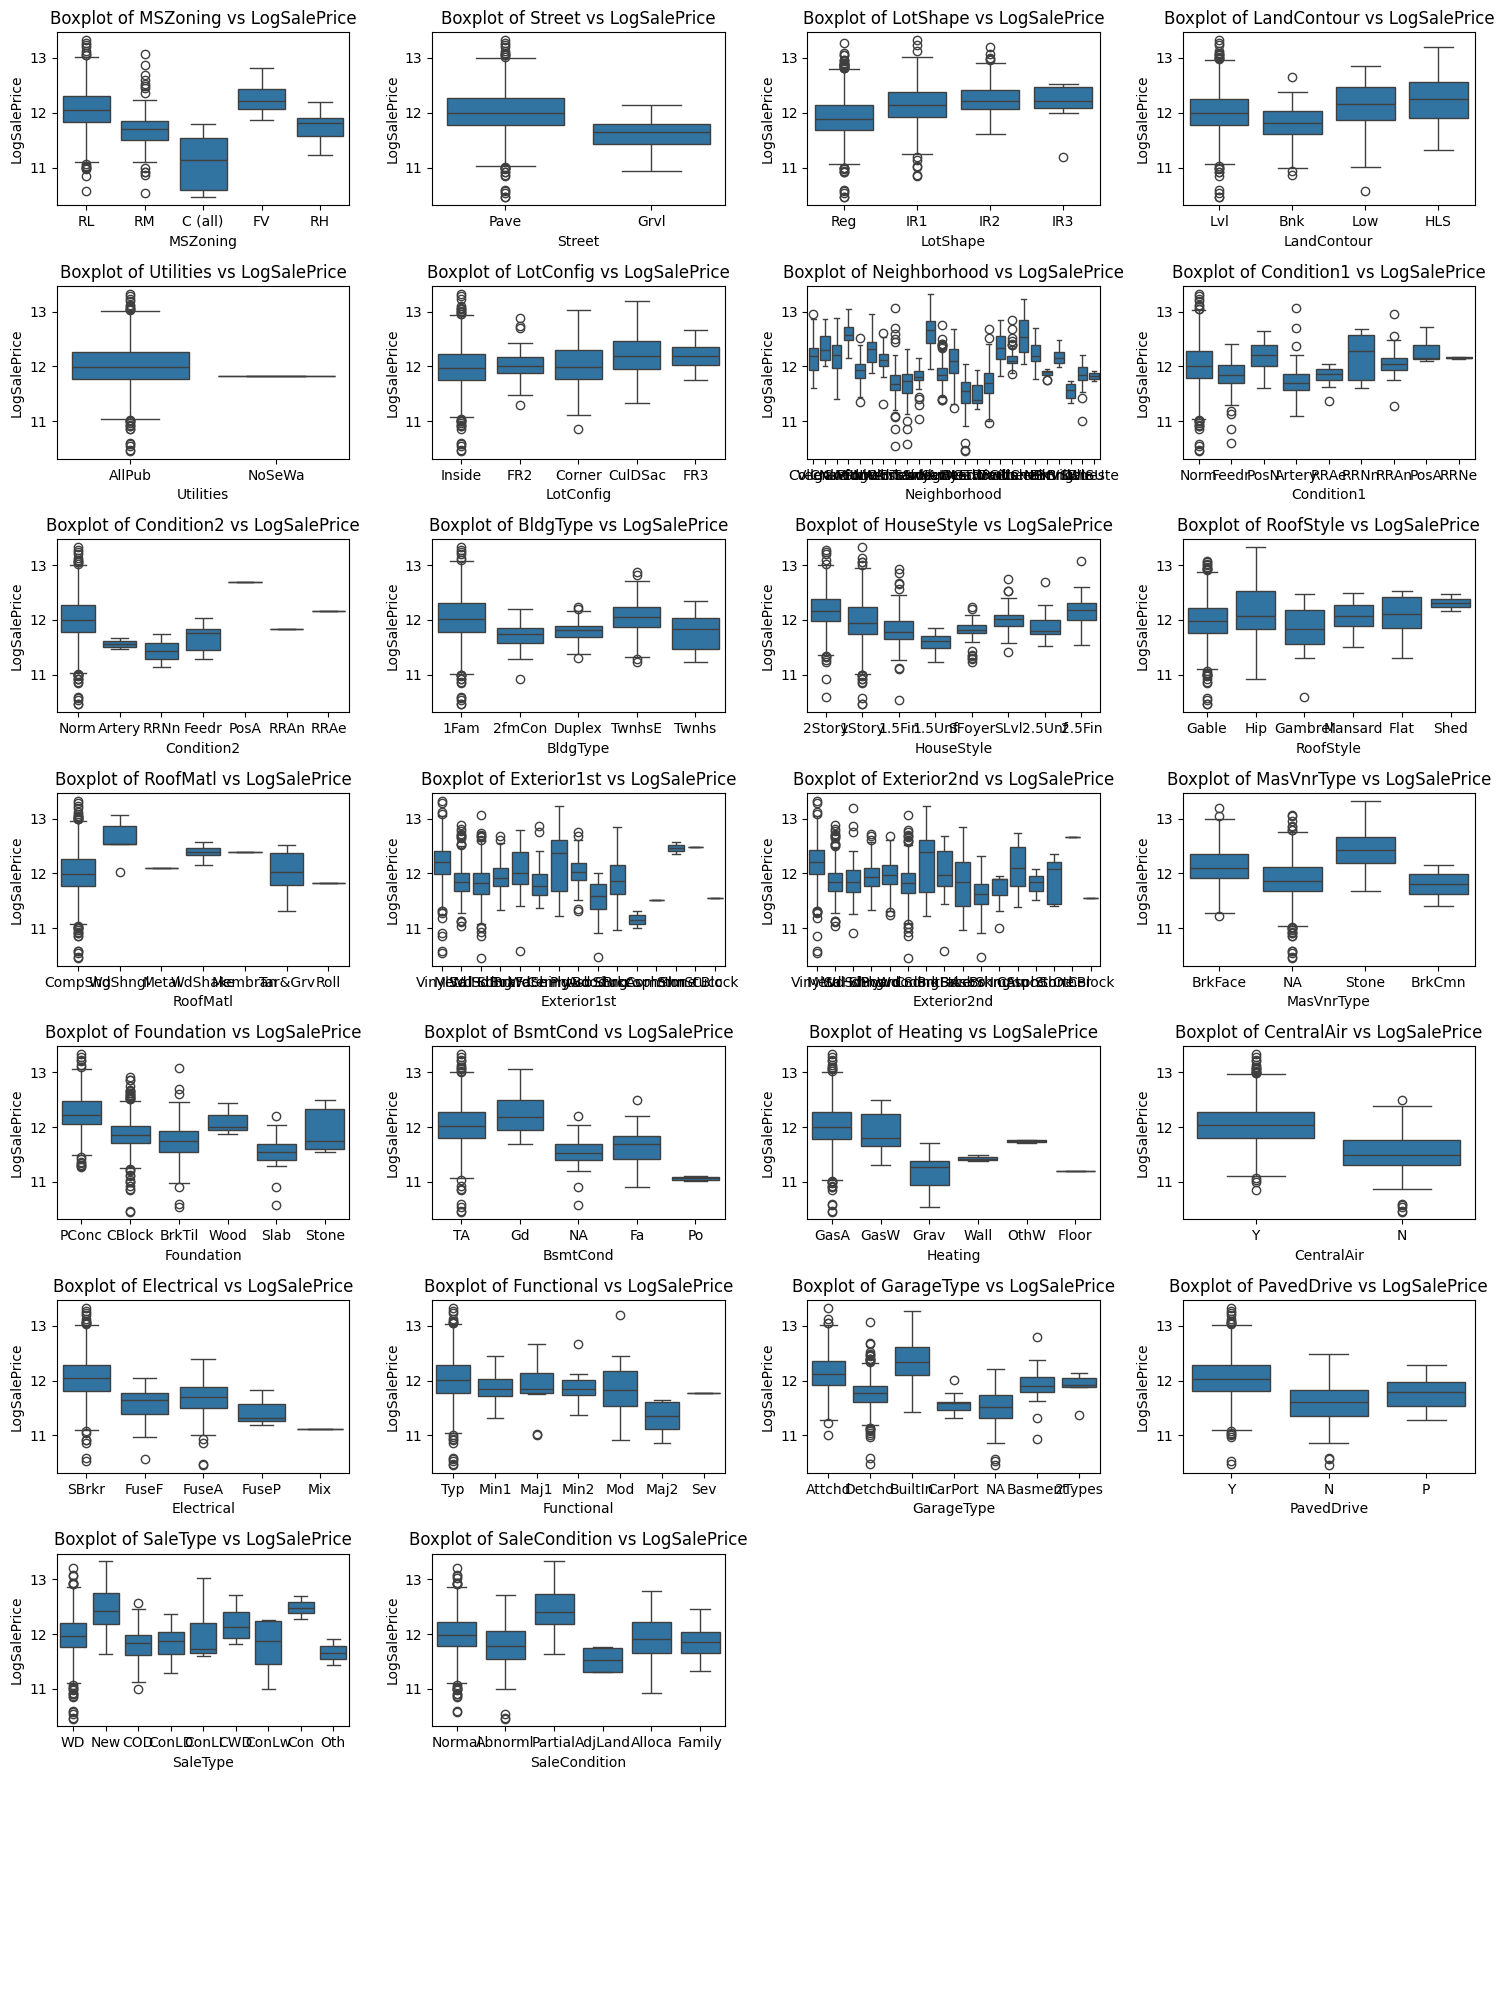

In [28]:
#boxplots for categorical features
n_rows = 8
n_cols = 4

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjusted figsize for better readability

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot boxplots for each numeric ordinal feature
for col, ax in enumerate(axes):
    if col < len(cat_normal):
        col_name = cat_normal[col]
        sns.boxplot(x=col_name, y='LogSalePrice', data=df, ax=ax)
        ax.set_title(f'Boxplot of {col_name} vs LogSalePrice')
    else:
        ax.axis('off')  # Hide unused subplots

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
df.drop(columns = ['Utilities'],inplace=True)

## Save Cleaned Data

In [30]:
save_train = os.path.join('data_set','cleaned_train.csv')
df.to_csv(
    save_train,          # File path
    index=False,           # Exclude row indices          
    header=True            # Include column names
)